In [1]:
# !pip install pillow
# !pip install opencv-python
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow==2.10
# !pip install scikit-learn

**Ini merupakan project computer vision untuk deteksi kantuk pengemudi kendaraan yang menggunakan algoritma Convolutional Neural Network (CNN) dengan pengimplementasian Transfer Learning DenseNet169 menggunakan library tensorflow**

Dataset: https://www.kaggle.com/datasets/hazemfahmy/openned-closed-eyes/data

by Hazem Fahmy

**Tentang Dataset**

Selamat datang di Dataset Deteksi Kantuk UnityEyes! Dataset komprehensif ini dirancang untuk membantu para peneliti dan pengembang dalam tugas penting deteksi kantuk, yang secara khusus berfokus pada identifikasi pengemudi yang mengantuk berdasarkan perilaku mata. Dataset ini dikumpulkan menggunakan UnityEyes, sebuah simulator sintetis mata yang canggih, untuk memastikan data berkualitas tinggi. Data tersebut diberi label menggunakan ambang batas keterbukaan = 20 (referensi: https://github.com/SNTSVV/HUDD-Toolset)

Dataset Deteksi Mengantuk terdiri dari beragam koleksi rekaman gerakan mata dari subjek dengan demografi yang berbeda-beda, yang diambil dalam skenario mengemudi yang terkendali. Data tersebut mencakup urutan gambar mata, yang diberi label secara cermat untuk menunjukkan apakah mata terbuka atau tertutup, yang berfungsi sebagai kebenaran dasar untuk mendeteksi pengemudi yang mengantuk.

## **Import Library**

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import  Image
import string

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)

2.12.0


In [2]:
import warnings
# Abaikan semua warning
warnings.filterwarnings('ignore')

Beberapa fungsi library yang digunakan:
- **os**: Untuk mengoperasikan sistem operasi.
- **cv2**: OpenCV untuk tugas-tugas computer vision.
- **PIL**: Library pencitraan Python untuk tugas-tugas pemrosesan gambar.
- **numpy**: Untuk komputasi numerik dan matriks.
- **matplotlib.pyplot**: Untuk visualisasi plot.
- **seaborn**: Untuk visualisasi plot.
- **sklearn**: Untuk preprocessing data dan evaluasi akurasi
- **tensorflow**: Untuk membangun dan melatih model pembelajaran mesin.

## **Load Data from Directory**

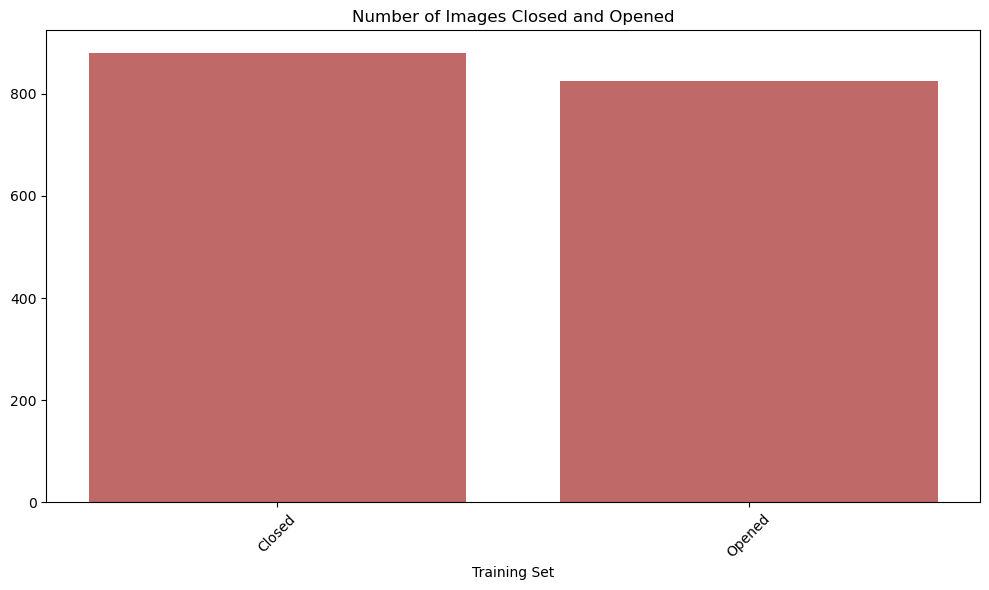

In [3]:
# directory yang mengandung Image
root_dir = './drownisess/TrainingSet/TrainingSet'

# Iterasi melalui setiap folder di direktori root
folder_image_count = {}

for data in os.listdir(root_dir):
    path_folder = os.path.join(root_dir, data)
    if os.path.isdir(path_folder):
        # Menghitung jumlah file gambar di dalam folder
        num_images = len([name for name in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
        folder_image_count[data] = num_images

# Extract nama folder dan jumlah gambar yang sesuai
folders = list(folder_image_count.keys())
img_counts = list(folder_image_count.values())

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(folders)), img_counts, color = 'brown', align='center', alpha=0.7)
plt.xticks(range(len(folders)), folders, rotation=45)
plt.xlabel('Training Set')
plt.title('Number of Images Closed and Opened')
plt.tight_layout()
plt.show()

Setelah melakukan exttact data dari direktori path yang telah ditentukan, di dapatkan data Training Set yang terdiri dari 2 data mata Terbuka dengan 824 gambar dan mata Mengantuk dengan 880 gambar. Pastikan folder dataset berada ditempat yang sama seperti folder .py atau jupyter anda.

Contoh direktori yang benar:

**Project**

----- **drownisess**
 
----- **drownisess-detection.ipynb**

## **Preprocessing Data**

Setelah dilakukan extract data, akan dilakukan transform data. Dataset akan dikelompokan berdasarkan label masing-masing lalu dilakukan resize image untuk mengcompress gambar mnejadi ukuran 150x150 dengan 3 channel warna karena merupakan gambar RGB.

In [4]:
categories = ['Opened', 'Closed'] # Folder yang akan dimuat
image_size = (150, 150) # Untuk setting ukuran gambar

# Inisialisasi list untuk menyimpan data dan label
X = []
Y = []

# Memuat gambar dan label dari setiap folder
for label, category in enumerate(categories):
    folder_path = os.path.join(root_dir, category)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(image_size)  # Mengubah ukuran gambar
            img_array = np.array(img)     # Mengonversi gambar menjadi array numpy
            X.append(img_array)
            Y.append(label)

# Mengonversi list X dan Y menjadi array numpy
X = np.array(X)
Y = np.array(Y)

Label mata terbuka **“Opened”: 0** dan Label mata mengantuk **“Closed”: 1**

In [5]:
print(f'Total gambar: {len(X)}')
print(f'Total label: {len(Y)}')
print('kode label:', np.unique(Y))

Total gambar: 1704
Total label: 1704
kode label: [0 1]


In [6]:
X[0]

array([[[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       ...,

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]]], dtype=uint8)

Melakukan load data yang telah di extract dan di transform untuk melihat 5 sampel masing-masing setiap label

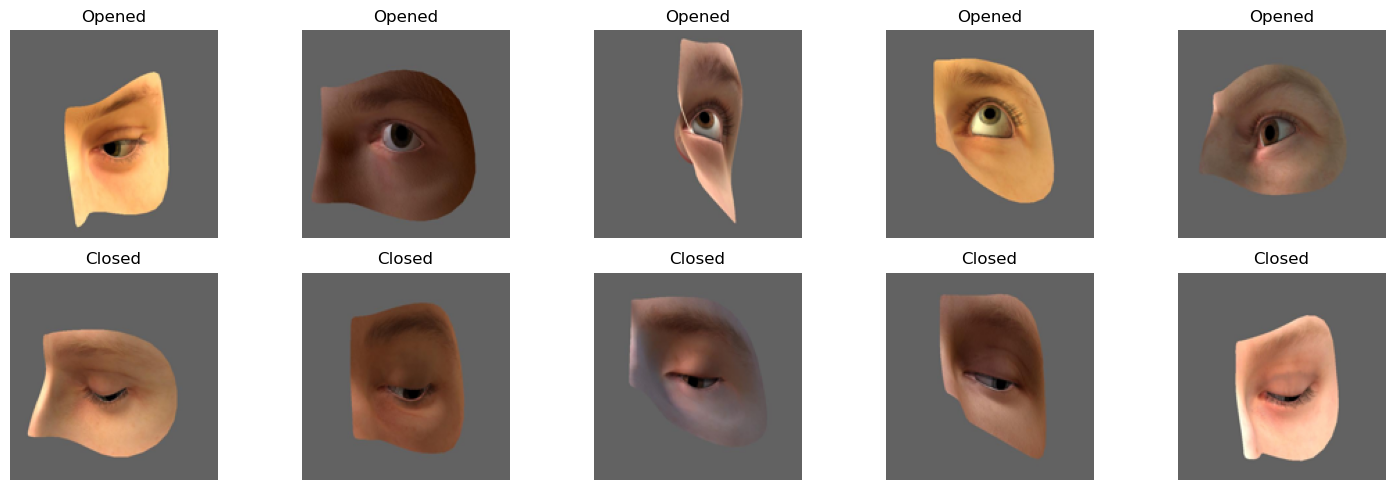

In [7]:
# Memisahkan gambar berdasarkan label
X_opened = X[Y == 0]
X_closed = X[Y == 1]

# Mengambil 5 sampel acak dari masing-masing kategori
opened_samples = np.random.choice(len(X_opened), 5, replace=False)
closed_samples = np.random.choice(len(X_closed), 5, replace=False)

X_samples = np.concatenate((X_opened[opened_samples], X_closed[closed_samples]))
Y_samples = np.concatenate((np.zeros(5), np.ones(5)))

# Menampilkan 10 sampel gambar
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_samples[i])
    plt.title('Opened' if Y_samples[i] == 0 else 'Closed')
    plt.axis('off')
plt.tight_layout()
plt.show()

Membagi data menjadi data training 90% dan data validation 10%

In [8]:
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.1, random_state=79)

In [9]:
print(x_train.shape)
print(y_train.shape)

(1533, 150, 150, 3)
(1533,)


terdapat 1533 gambar untuk data training

In [10]:
print(x_validation.shape)
print(y_validation.shape)

(171, 150, 150, 3)
(171,)


terdapat 171 gambar untuk data validation

In [11]:
# Mengonversi y_train dan y_validation menjadi kategorikal (one-hot encoded vectors.)
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)

## **Model 1 CNN + DenseNet169 [Trainable layer - Regularization Yes - Batch Size 32]**

Model pertama adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 dengan melakukan training layer DenseNet169, memakai regularization dan batch size = 32

In [12]:
# Define jumlah kelas
num_classes = 2

In [14]:
# model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet')
# model.summary()


In [15]:
# # Load base model dengan DenseNet121
# base_model = tf.keras.applications.DenseNet121(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape = (150, 150, 3),
#     classes=2,
# )

# # Membuka 24 layer terakhir kecuali BatchNormalization
# base_model.trainable = True
# layer_count = len(base_model.layers)
# layer_count

In [16]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_DenseNet169_1
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)  # Menambahkan weight regularization
)(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_DenseNet169_1
model_DenseNet169_1 = Model(inputs, outputs)

# Compile model_DenseNet169_1
model_DenseNet169_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_1 = ModelCheckpoint(
    'best_model_DenseNet169_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_1 dengan batch size 32
batch_size = 32
historyDenseNet169_1 = model_DenseNet169_1.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_1, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 6.5676 - accuracy: 0.8030
Epoch 1: val_accuracy improved from -inf to 0.93567, saving model to best_model_DenseNet169_1.h5
48/48 [==============================] - 73s 1s/step - loss: 6.5676 - accuracy: 0.8030 - val_loss: 3.0794 - val_accuracy: 0.9357
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 2.1771 - accuracy: 0.9256
Epoch 2: val_accuracy did not improve from 0.93567
48/48 [==============================] - 62s 1s/step - loss: 2.1771 - accuracy: 0.9256 - val_loss: 2.2939 - val_accuracy: 0.8187
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 1.3139 - accuracy: 0.9250
Epoch 3: val_accuracy did not improve from 0.93567
48/48 [==============================] - 69s 1s/step - loss: 1.3139 - accuracy: 0.9250 - val_loss: 1.1065 - val_accuracy: 0.8889
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.8700 - accuracy: 0.9282
Epoch 4: val_accuracy did not improve 

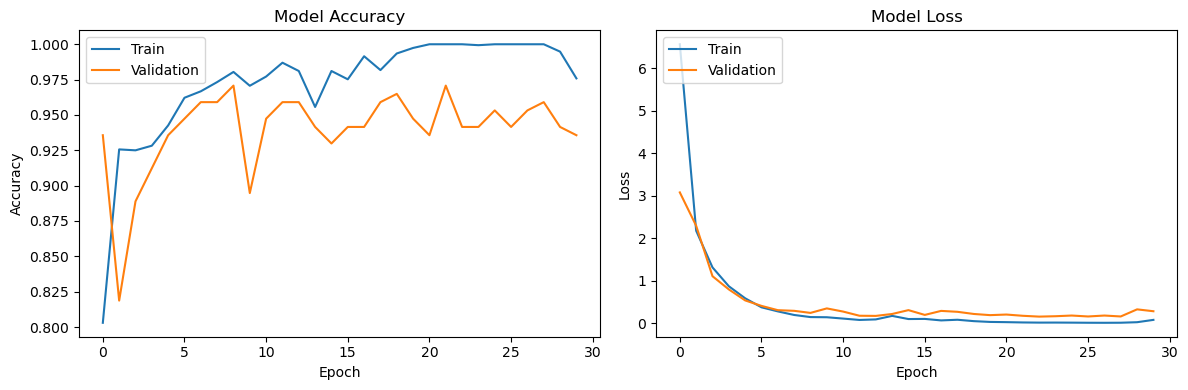

In [17]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_1.history['accuracy'])
ax1.plot(historyDenseNet169_1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_1.history['loss'])
ax2.plot(historyDenseNet169_1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_1.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_1.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_1 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 1:')
print(class_report_DenseNet169_1)

6/6 [==============================] - 6s 928ms/step - loss: 0.2817 - accuracy: 0.9357
validation accuracy: 93.567%
validation loss: 0.2817
6/6 [==============================] - 8s 979ms/step
Classification Report Model CNN + DenseNet169 1:
              precision    recall  f1-score   support

      Opened       0.92      0.95      0.94        87
      Closed       0.95      0.92      0.93        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[83  4]
 [ 7 77]]


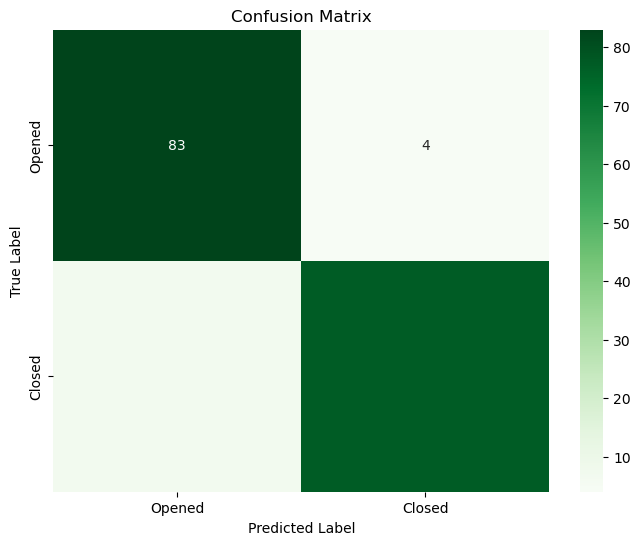

In [19]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 1**

1/1 [==============================] - 0s 63ms/step


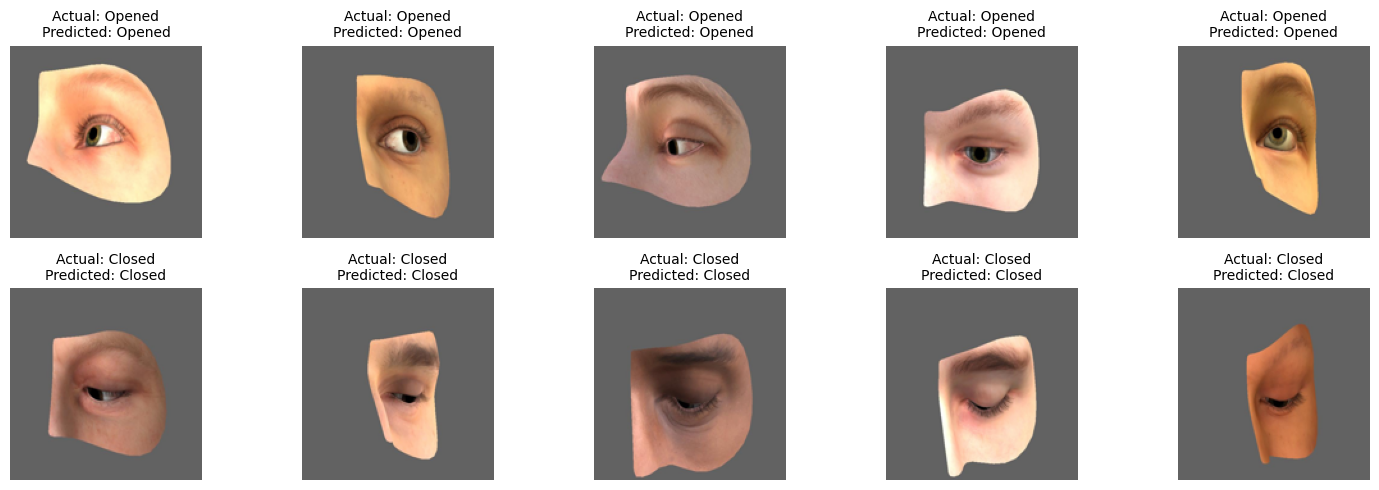

In [20]:
# Load model_predict_1 .h5
model_predict_1 = tf.keras.models.load_model('best_model_DenseNet169_1.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_1.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 2 CNN + DenseNet169 [No Trainable layer - Regularization Yes - Batch Size 32]**

Model kedua adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 tanpa melakukan training layer DenseNet169, memakai regularization dan batch size = 32

In [21]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_DenseNet169_2
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_DenseNet169_2
model_DenseNet169_2 = Model(inputs, outputs)

# Compile model_DenseNet169_2
model_DenseNet169_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_2 = ModelCheckpoint(
    'best_model_DenseNet169_2.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_2 dengan batch size 32
batch_size = 32
historyDenseNet169_2 = model_DenseNet169_2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_2, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 10.2369 - accuracy: 0.6464
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to best_model_DenseNet169_2.h5
48/48 [==============================] - 70s 1s/step - loss: 10.2369 - accuracy: 0.6464 - val_loss: 3.9941 - val_accuracy: 0.7778
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 3.5565 - accuracy: 0.7867
Epoch 2: val_accuracy improved from 0.77778 to 0.89474, saving model to best_model_DenseNet169_2.h5
48/48 [==============================] - 59s 1s/step - loss: 3.5565 - accuracy: 0.7867 - val_loss: 2.7773 - val_accuracy: 0.8947
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 2.6499 - accuracy: 0.8278
Epoch 3: val_accuracy did not improve from 0.89474
48/48 [==============================] - 62s 1s/step - loss: 2.6499 - accuracy: 0.8278 - val_loss: 2.4217 - val_accuracy: 0.7778
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 2.1266 - accu

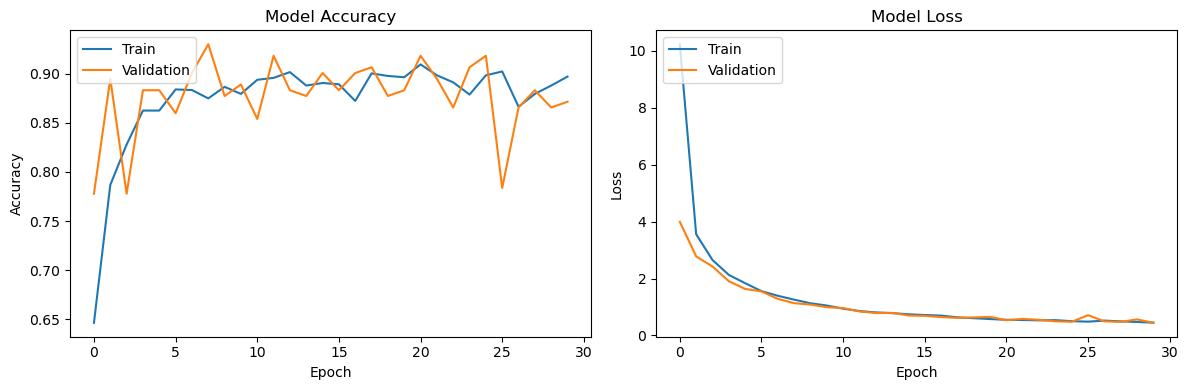

In [22]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_2.history['accuracy'])
ax1.plot(historyDenseNet169_2.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_2.history['loss'])
ax2.plot(historyDenseNet169_2.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_2.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_2.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_2 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 2:')
print(class_report_DenseNet169_2)

6/6 [==============================] - 5s 861ms/step - loss: 0.4426 - accuracy: 0.8713
validation accuracy: 87.135%
validation loss: 0.4426
6/6 [==============================] - 8s 885ms/step
Classification Report Model CNN + DenseNet169 2:
              precision    recall  f1-score   support

      Opened       0.85      0.91      0.88        87
      Closed       0.90      0.83      0.86        84

    accuracy                           0.87       171
   macro avg       0.87      0.87      0.87       171
weighted avg       0.87      0.87      0.87       171



Confusion Matrix:
[[79  8]
 [14 70]]


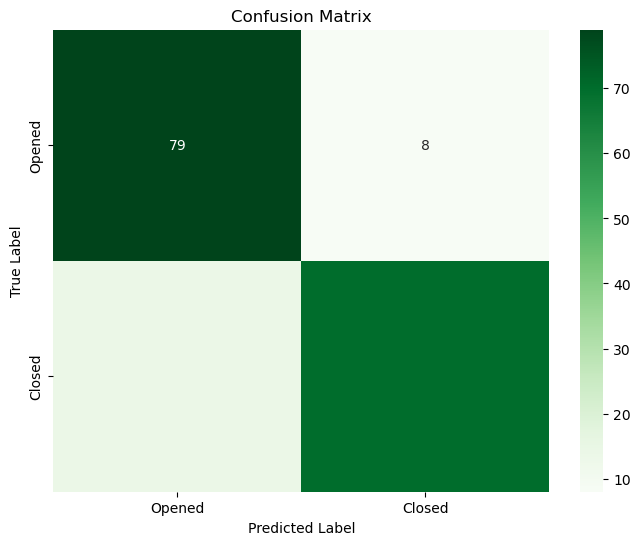

In [24]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 2**

1/1 [==============================] - 0s 68ms/step


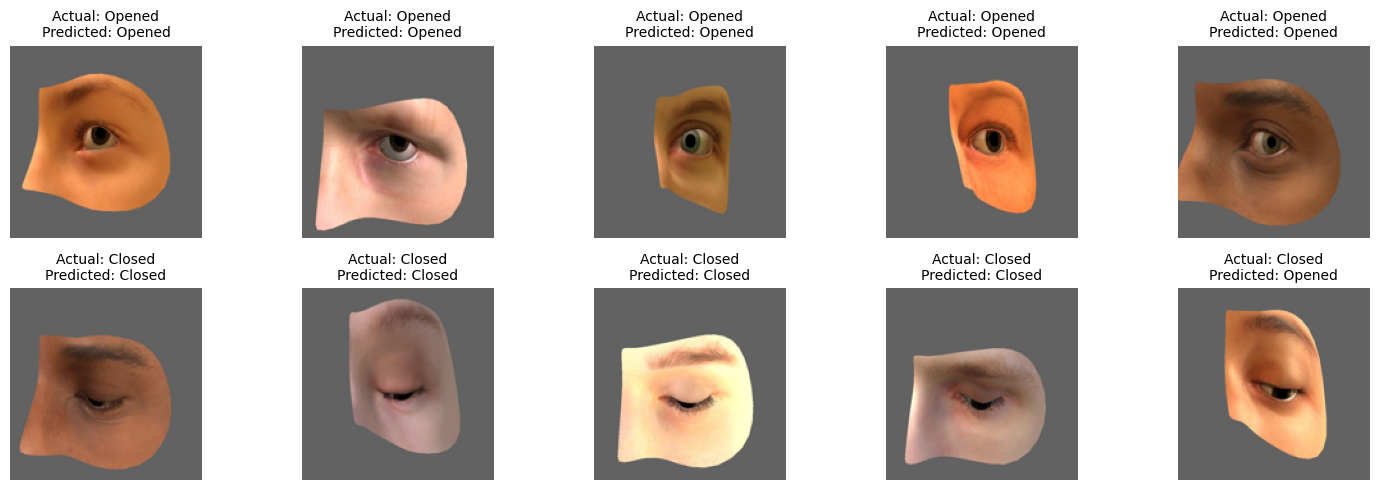

In [25]:
# Load model_predict_2 .h5
model_predict_2 = tf.keras.models.load_model('best_model_DenseNet169_2.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_2.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 3 CNN + DenseNet169 [Trainable layer - Regularization No - Batch Size 32]**

Model ketiga adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 dengan melakukan training layer DenseNet169, tanpa regularization dan batch size = 32

In [26]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_DenseNet169_3
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_DenseNet169_3
model_DenseNet169_3 = Model(inputs, outputs)

# Compile model_DenseNet169_3
model_DenseNet169_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_3 = ModelCheckpoint(
    'best_model_DenseNet169_3.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_3 dengan batch size 32
batch_size = 32
historyDenseNet169_3 = model_DenseNet169_3.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_3, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.7873
Epoch 1: val_accuracy improved from -inf to 0.90058, saving model to best_model_DenseNet169_3.h5
48/48 [==============================] - 93s 2s/step - loss: 0.8049 - accuracy: 0.7873 - val_loss: 0.4080 - val_accuracy: 0.9006
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9126
Epoch 2: val_accuracy improved from 0.90058 to 0.92982, saving model to best_model_DenseNet169_3.h5
48/48 [==============================] - 67s 1s/step - loss: 0.2286 - accuracy: 0.9126 - val_loss: 0.2019 - val_accuracy: 0.9298
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9413
Epoch 3: val_accuracy improved from 0.92982 to 0.94152, saving model to best_model_DenseNet169_3.h5
48/48 [==============================] - 60s 1s/step - loss: 0.1592 - accuracy: 0.9413 - val_loss: 0.1295 - val_accuracy: 0.9415
Epoch 4/30
48/48 [================

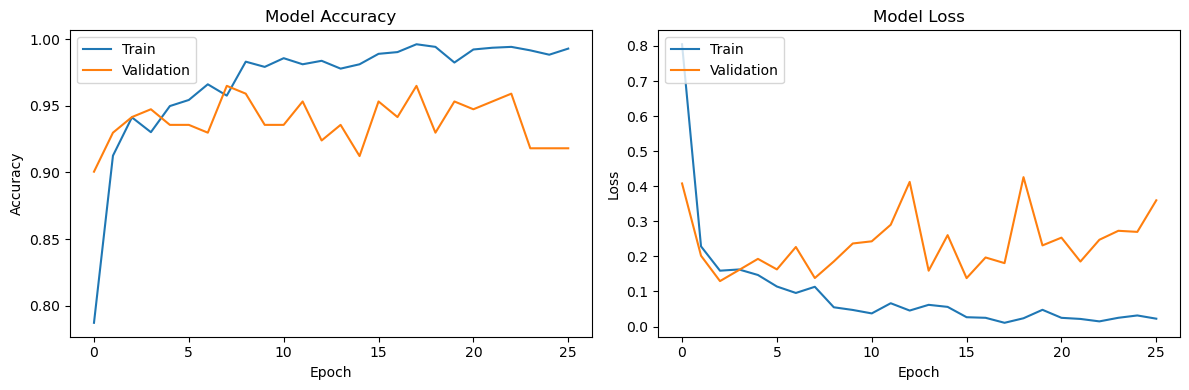

In [27]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_3.history['accuracy'])
ax1.plot(historyDenseNet169_3.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_3.history['loss'])
ax2.plot(historyDenseNet169_3.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_3.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_3.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_3 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 3:')
print(class_report_DenseNet169_3)

6/6 [==============================] - 7s 1s/step - loss: 0.1380 - accuracy: 0.9532
validation accuracy: 95.322%
validation loss: 0.1380
6/6 [==============================] - 12s 1s/step
Classification Report Model CNN + DenseNet169 3:
              precision    recall  f1-score   support

      Opened       0.93      0.98      0.96        87
      Closed       0.97      0.93      0.95        84

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



Confusion Matrix:
[[85  2]
 [ 6 78]]


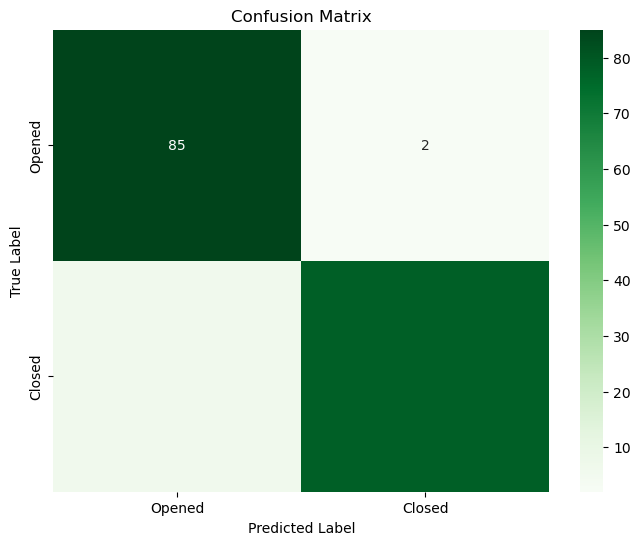

In [29]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 3**

1/1 [==============================] - 0s 79ms/step


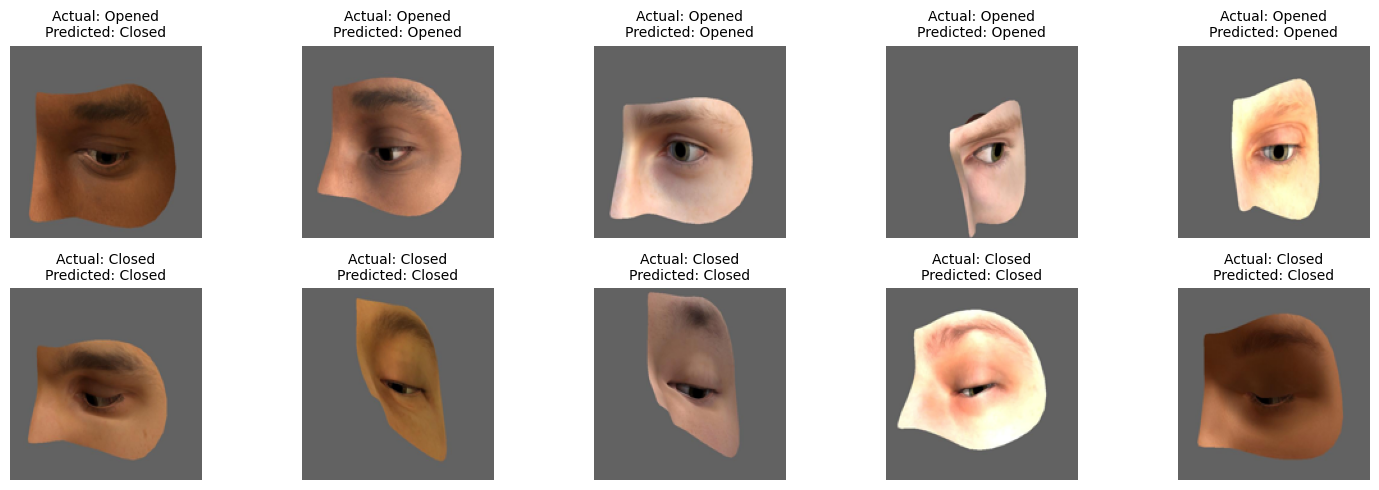

In [30]:
# Load model_predict_3 .h5
model_predict_3 = tf.keras.models.load_model('best_model_DenseNet169_3.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_3.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 4 CNN + DenseNet169 [No Trainable layer - Regularization No - Batch Size 32]**

Model keempat adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 tanpa melakukan training layer DenseNet169, tanpa regularization dan batch size = 32

In [31]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_DenseNet169_4
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_DenseNet169_4
model_DenseNet169_4 = Model(inputs, outputs)

# Compile model_DenseNet169_4
model_DenseNet169_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_4 = ModelCheckpoint(
    'best_model_DenseNet169_4.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_4 dengan batch size 32
batch_size = 32
historyDenseNet169_4 = model_DenseNet169_4.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_4, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 2.0812 - accuracy: 0.6960
Epoch 1: val_accuracy improved from -inf to 0.83626, saving model to best_model_DenseNet169_4.h5
48/48 [==============================] - 88s 2s/step - loss: 2.0812 - accuracy: 0.6960 - val_loss: 0.6108 - val_accuracy: 0.8363
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.7769
Epoch 2: val_accuracy improved from 0.83626 to 0.89474, saving model to best_model_DenseNet169_4.h5
48/48 [==============================] - 85s 2s/step - loss: 1.0014 - accuracy: 0.7769 - val_loss: 0.4753 - val_accuracy: 0.8947
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.8252
Epoch 3: val_accuracy did not improve from 0.89474
48/48 [==============================] - 79s 2s/step - loss: 0.6219 - accuracy: 0.8252 - val_loss: 0.4272 - val_accuracy: 0.8246
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.4436 - accura

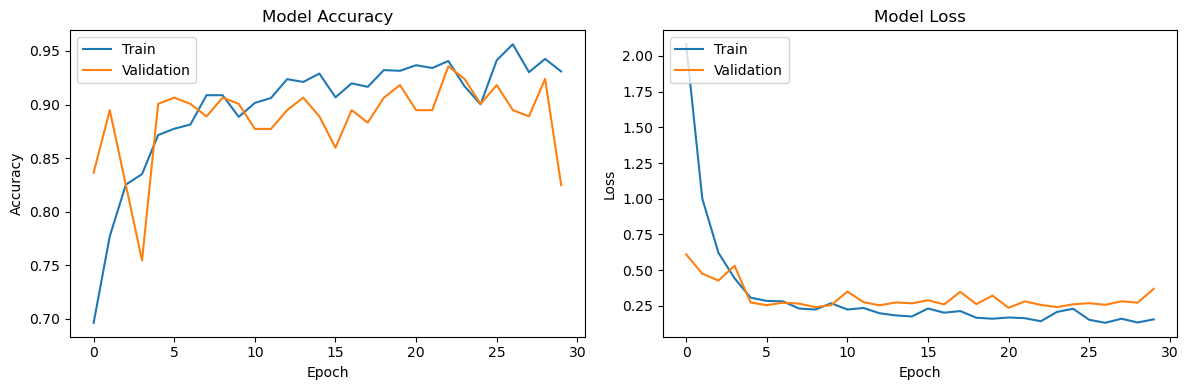

In [32]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_4.history['accuracy'])
ax1.plot(historyDenseNet169_4.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_4.history['loss'])
ax2.plot(historyDenseNet169_4.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [33]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_4.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_4.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_4 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 4:')
print(class_report_DenseNet169_4)

6/6 [==============================] - 8s 1s/step - loss: 0.3693 - accuracy: 0.8246
validation accuracy: 82.456%
validation loss: 0.3693
6/6 [==============================] - 16s 2s/step
Classification Report Model CNN + DenseNet169 4:
              precision    recall  f1-score   support

      Opened       0.76      0.95      0.85        87
      Closed       0.94      0.69      0.79        84

    accuracy                           0.82       171
   macro avg       0.85      0.82      0.82       171
weighted avg       0.85      0.82      0.82       171



Confusion Matrix:
[[83  4]
 [26 58]]


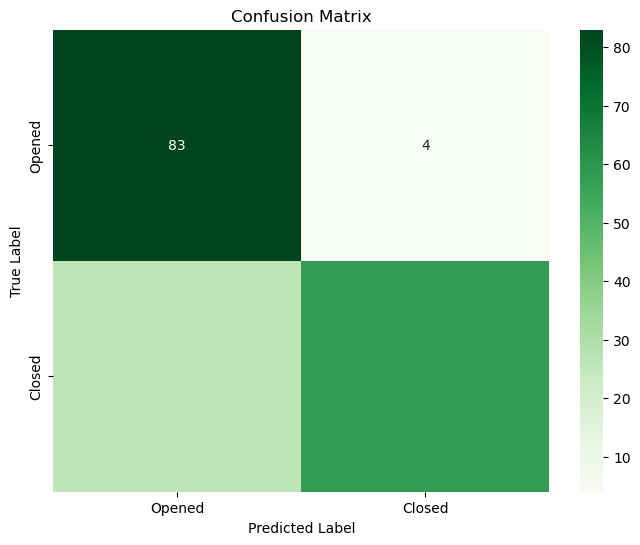

In [34]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 4**

1/1 [==============================] - 0s 95ms/step


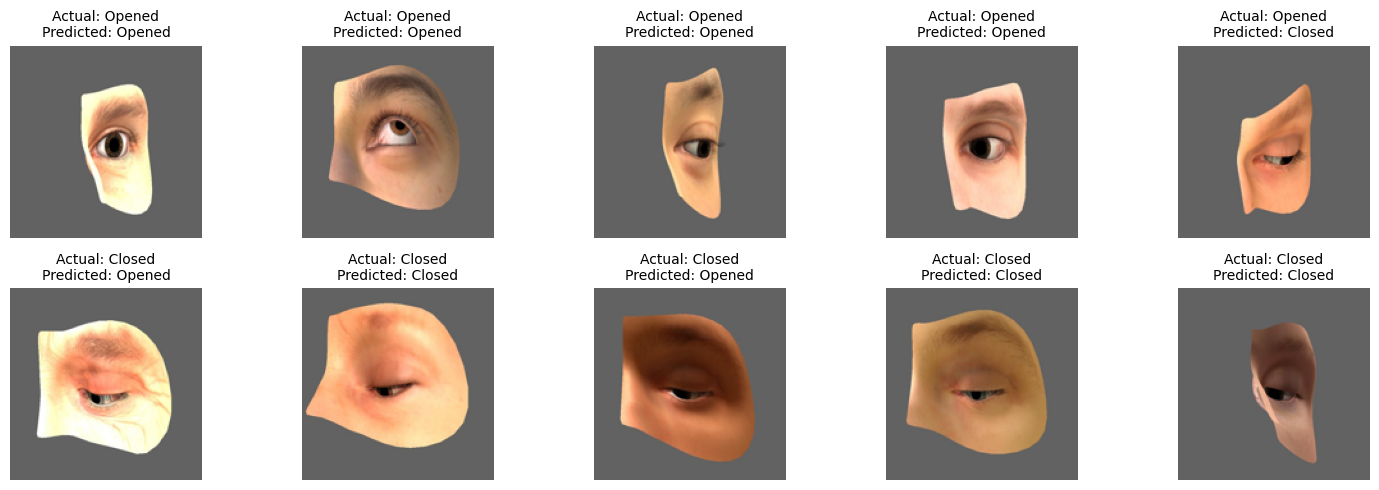

In [35]:
# Load model_predict_4 .h5
model_predict_4 = tf.keras.models.load_model('best_model_DenseNet169_4.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_4.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 5 CNN + DenseNet169 [Trainable layer - Regularization Yes - Batch Size 64]**

Model kelima adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 dengan melakukan training layer DenseNet169, memakai regularization dan batch size = 64

In [36]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_DenseNet169_5
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)  # Menambahkan weight regularization
)(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_DenseNet169_5
model_DenseNet169_5 = Model(inputs, outputs)

# Compile model_DenseNet169_5
model_DenseNet169_5.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_5 = ModelCheckpoint(
    'best_model_DenseNet169_5.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_5 dengan batch size 64
batch_size = 64
historyDenseNet169_5 = model_DenseNet169_5.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_5, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 8.8431 - accuracy: 0.7671
Epoch 1: val_accuracy improved from -inf to 0.51462, saving model to best_model_DenseNet169_5.h5
24/24 [==============================] - 78s 3s/step - loss: 8.8431 - accuracy: 0.7671 - val_loss: 11.1617 - val_accuracy: 0.5146
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 3.6600 - accuracy: 0.9178
Epoch 2: val_accuracy improved from 0.51462 to 0.90643, saving model to best_model_DenseNet169_5.h5
24/24 [==============================] - 61s 3s/step - loss: 3.6600 - accuracy: 0.9178 - val_loss: 2.7734 - val_accuracy: 0.9064
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 2.1819 - accuracy: 0.9419
Epoch 3: val_accuracy did not improve from 0.90643
24/24 [==============================] - 63s 3s/step - loss: 2.1819 - accuracy: 0.9419 - val_loss: 2.6203 - val_accuracy: 0.7661
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 1.5836 - accur

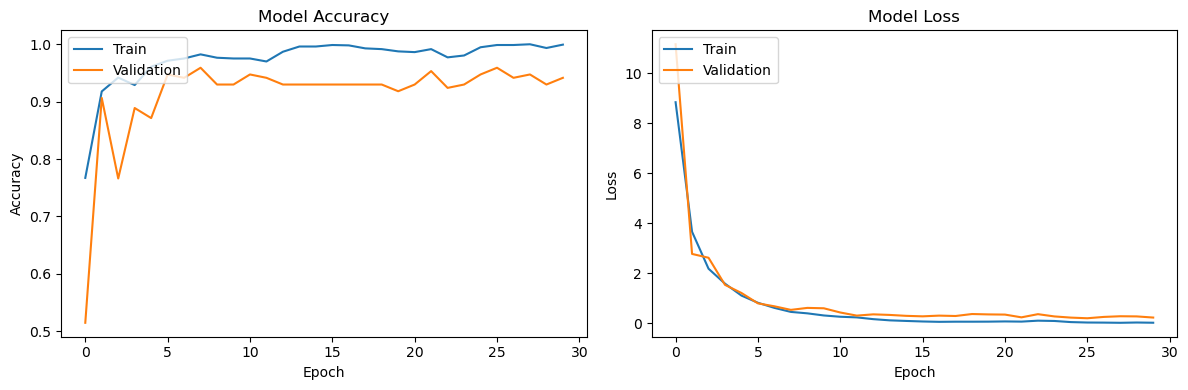

In [37]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_5.history['accuracy'])
ax1.plot(historyDenseNet169_5.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_5.history['loss'])
ax2.plot(historyDenseNet169_5.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_5.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_5.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_5 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 5:')
print(class_report_DenseNet169_5)

6/6 [==============================] - 6s 1s/step - loss: 0.2277 - accuracy: 0.9415
validation accuracy: 94.152%
validation loss: 0.2277
6/6 [==============================] - 14s 2s/step
Classification Report Model CNN + DenseNet169 5:
              precision    recall  f1-score   support

      Opened       0.95      0.93      0.94        87
      Closed       0.93      0.95      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[81  6]
 [ 4 80]]


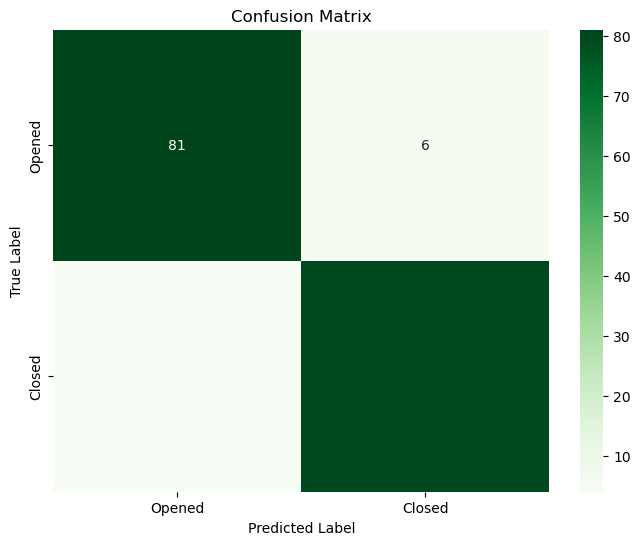

In [39]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 5**

1/1 [==============================] - 0s 105ms/step


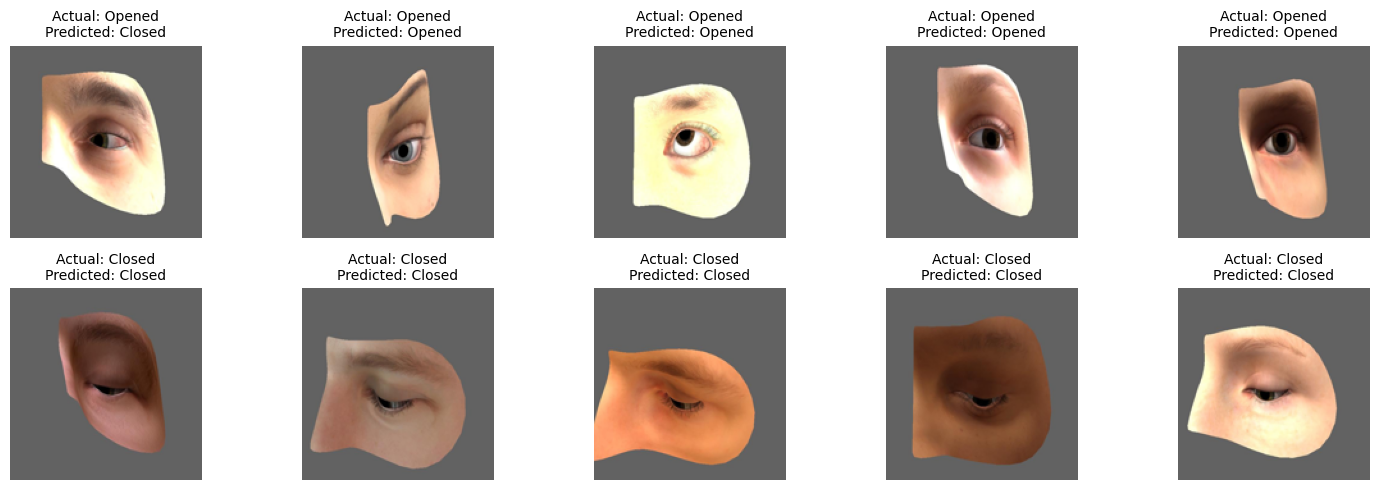

In [40]:
# Load model_predict_5 .h5
model_predict_5 = tf.keras.models.load_model('best_model_DenseNet169_5.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_5.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 6 CNN + DenseNet169 [No Trainable layer - Regularization Yes - Batch Size 64]**

Model keenam adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 tanpa melakukan training layer DenseNet169, memakai regularization dan batch size = 64

In [41]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_DenseNet169_6
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_DenseNet169_6
model_DenseNet169_6 = Model(inputs, outputs)

# Compile model_DenseNet169_6
model_DenseNet169_6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_6 = ModelCheckpoint(
    'best_model_DenseNet169_6.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_6 dengan batch size 64
batch_size = 64
historyDenseNet169_6 = model_DenseNet169_6.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_6, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 14.3240 - accuracy: 0.5858
Epoch 1: val_accuracy improved from -inf to 0.67836, saving model to best_model_DenseNet169_6.h5
24/24 [==============================] - 74s 2s/step - loss: 14.3240 - accuracy: 0.5858 - val_loss: 6.5989 - val_accuracy: 0.6784
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 5.0561 - accuracy: 0.7528
Epoch 2: val_accuracy improved from 0.67836 to 0.85965, saving model to best_model_DenseNet169_6.h5
24/24 [==============================] - 54s 2s/step - loss: 5.0561 - accuracy: 0.7528 - val_loss: 3.6681 - val_accuracy: 0.8596
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 3.5122 - accuracy: 0.8115
Epoch 3: val_accuracy improved from 0.85965 to 0.88889, saving model to best_model_DenseNet169_6.h5
24/24 [==============================] - 51s 2s/step - loss: 3.5122 - accuracy: 0.8115 - val_loss: 3.1350 - val_accuracy: 0.8889
Epoch 4/30
24/24 [==============

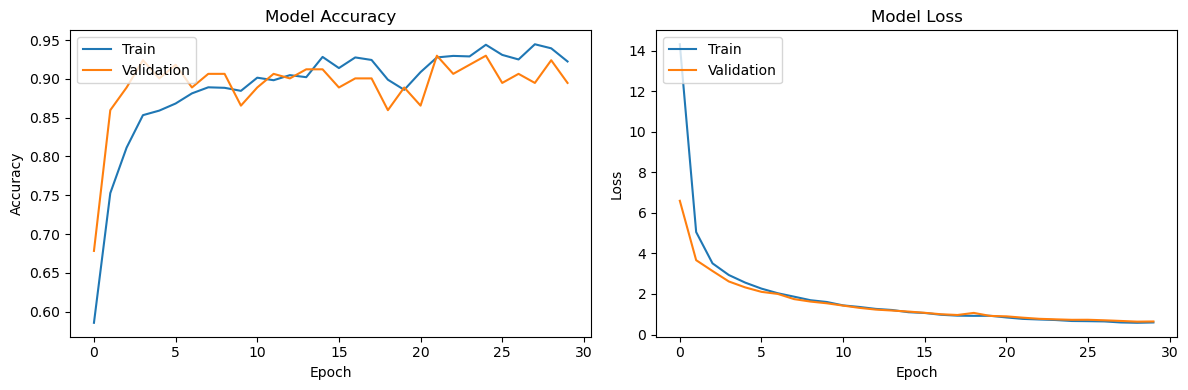

In [42]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_6.history['accuracy'])
ax1.plot(historyDenseNet169_6.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_6.history['loss'])
ax2.plot(historyDenseNet169_6.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_6.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_6.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_6 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 6:')
print(class_report_DenseNet169_6)

6/6 [==============================] - 6s 949ms/step - loss: 0.6435 - accuracy: 0.8947
validation accuracy: 89.474%
validation loss: 0.6435
6/6 [==============================] - 8s 922ms/step
Classification Report Model CNN + DenseNet169 6:
              precision    recall  f1-score   support

      Opened       0.88      0.92      0.90        87
      Closed       0.91      0.87      0.89        84

    accuracy                           0.89       171
   macro avg       0.90      0.89      0.89       171
weighted avg       0.90      0.89      0.89       171



Confusion Matrix:
[[80  7]
 [11 73]]


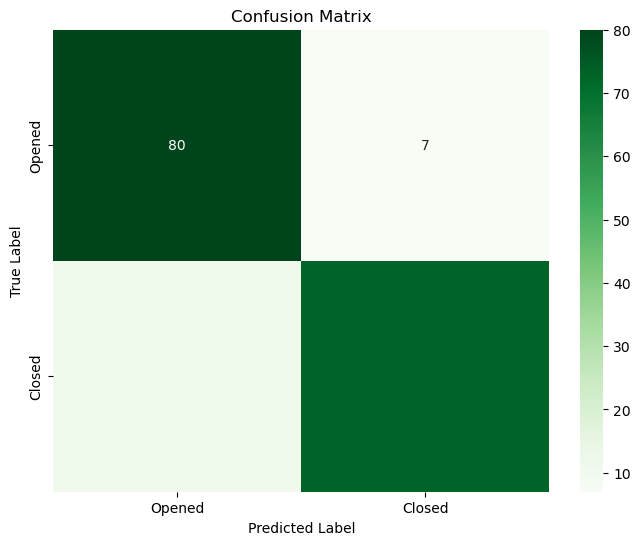

In [44]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 6**

1/1 [==============================] - 0s 95ms/step


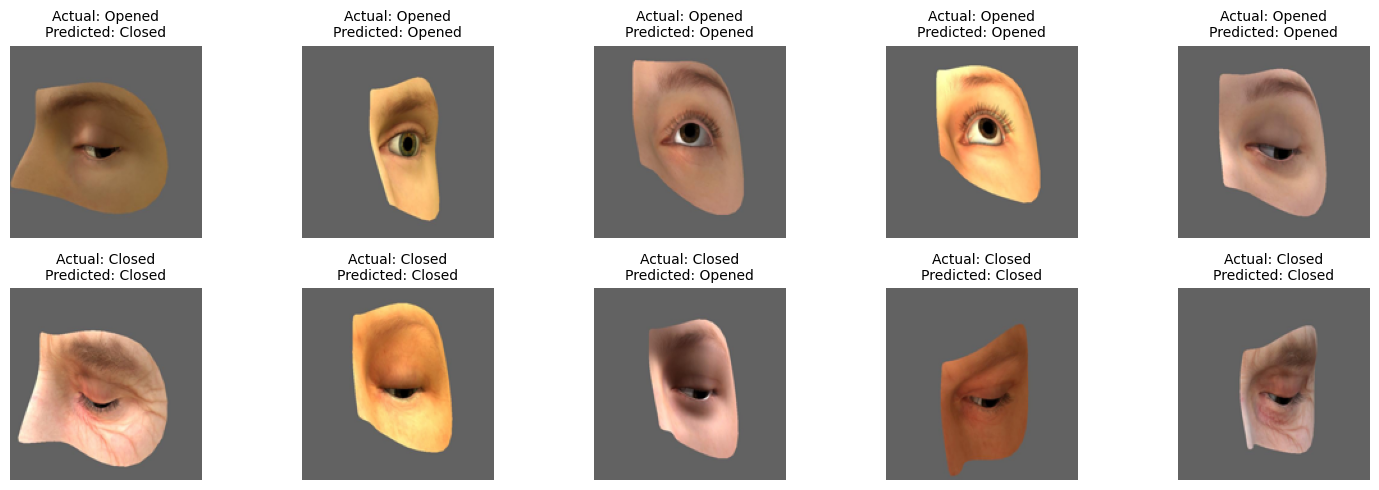

In [45]:
# Load model_predict_6 .h5
model_predict_6 = tf.keras.models.load_model('best_model_DenseNet169_6.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_6.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 7 CNN + DenseNet169 [Trainable layer - Regularization No - Batch Size 64]**

Model ketujuh adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 dengan melakukan training layer DenseNet169, tanpa regularization dan batch size = 64

In [13]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka beberapa layer terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Disable semua layer untuk dilatih kecuali 30 layer terakhir
    layer.trainable = False

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_DenseNet169_7
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_DenseNet169_7
model_DenseNet169_7 = Model(inputs, outputs)

# Compile model_DenseNet169_7
model_DenseNet169_7.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_7 = ModelCheckpoint(
    'best_model_DenseNet169_7.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_7 dengan batch size 64
batch_size = 64
historyDenseNet169_7 = model_DenseNet169_7.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_7, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.7567
Epoch 1: val_accuracy improved from -inf to 0.51462, saving model to best_model_DenseNet169_7.h5
24/24 [==============================] - 79s 3s/step - loss: 0.6495 - accuracy: 0.7567 - val_loss: 6.6824 - val_accuracy: 0.5146
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9041
Epoch 2: val_accuracy improved from 0.51462 to 0.69006, saving model to best_model_DenseNet169_7.h5
24/24 [==============================] - 54s 2s/step - loss: 0.2632 - accuracy: 0.9041 - val_loss: 1.6210 - val_accuracy: 0.6901
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9217
Epoch 3: val_accuracy improved from 0.69006 to 0.77193, saving model to best_model_DenseNet169_7.h5
24/24 [==============================] - 54s 2s/step - loss: 0.2004 - accuracy: 0.9217 - val_loss: 0.7959 - val_accuracy: 0.7719
Epoch 4/30
24/24 [================

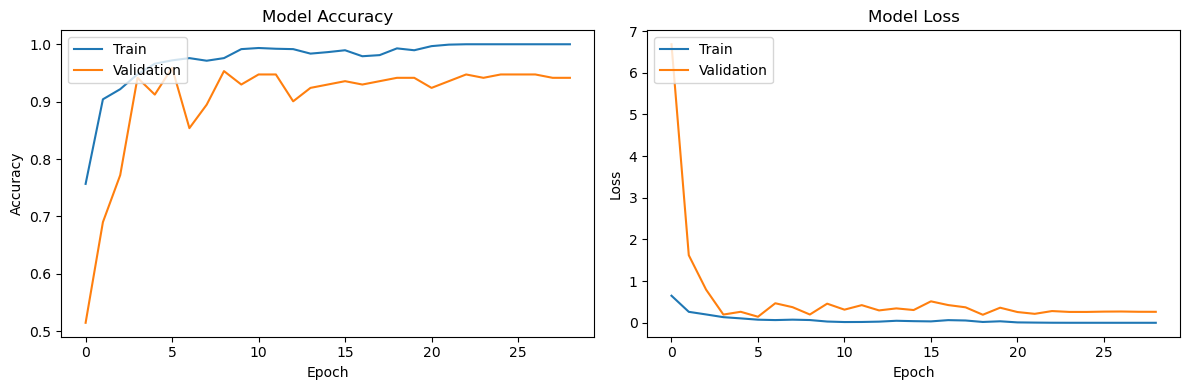

In [14]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_7.history['accuracy'])
ax1.plot(historyDenseNet169_7.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_7.history['loss'])
ax2.plot(historyDenseNet169_7.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_7.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_7.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_7 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 7:')
print(class_report_DenseNet169_7)

6/6 [==============================] - 6s 1s/step - loss: 0.1932 - accuracy: 0.9415
validation accuracy: 94.152%
validation loss: 0.1932
6/6 [==============================] - 8s 970ms/step
Classification Report Model CNN + DenseNet169 7:
              precision    recall  f1-score   support

      Opened       0.95      0.93      0.94        87
      Closed       0.93      0.95      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[81  6]
 [ 4 80]]


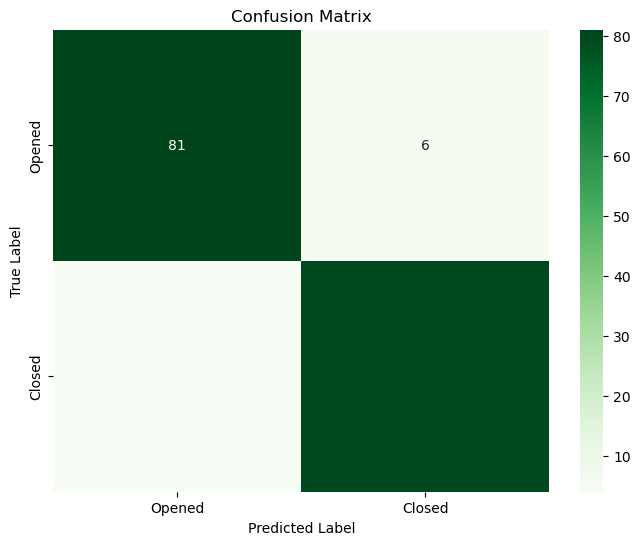

In [16]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 7**

1/1 [==============================] - 0s 63ms/step


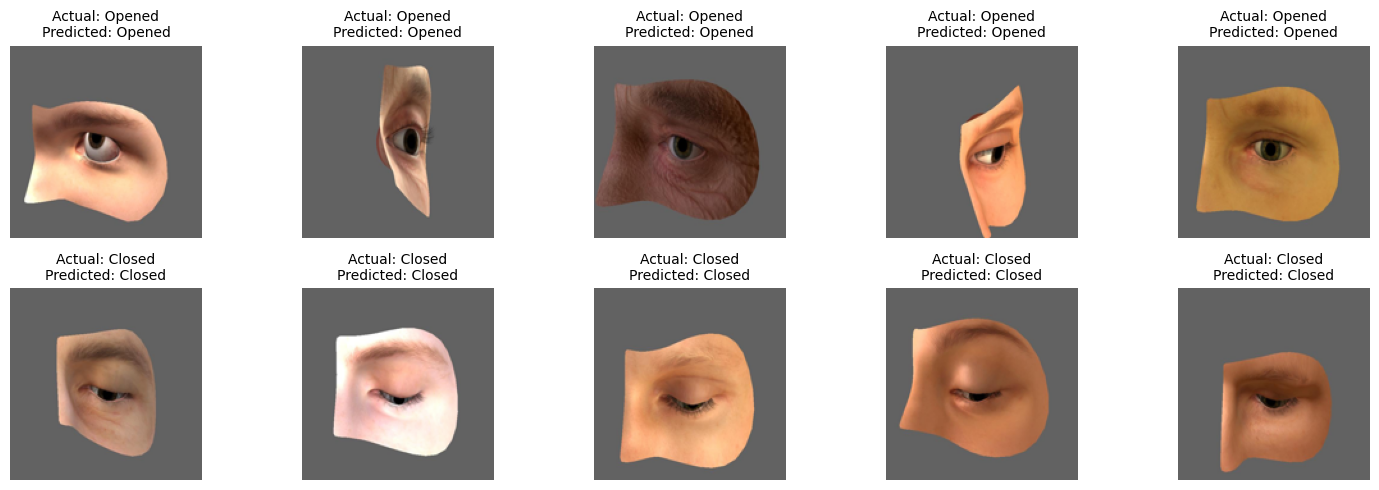

In [17]:
# Load model_predict_7 .h5
model_predict_7 = tf.keras.models.load_model('best_model_DenseNet169_7.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_7.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 8 CNN + DenseNet169 [No Trainable layer - Regularization No - Batch Size 64]**

Model kedepalapn adalah model CNN dengan memakai model DenseNet169 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning DenseNet169 tanpa melakukan training layer DenseNet169, tanpa regularization dan batch size = 64

In [24]:
# Load base model dengan DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_DenseNet169_8
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_DenseNet169_8
model_DenseNet169_8 = Model(inputs, outputs)

# Compile model_DenseNet169_8
model_DenseNet169_8.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointDenseNet169_8 = ModelCheckpoint(
    'best_model_DenseNet169_8.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_DenseNet169_8 dengan batch size 64
batch_size = 64
historyDenseNet169_8 = model_DenseNet169_8.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointDenseNet169_8, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 6.4590 - accuracy: 0.5623
Epoch 1: val_accuracy improved from -inf to 0.71930, saving model to best_model_DenseNet169_8.h5
24/24 [==============================] - 65s 2s/step - loss: 6.4590 - accuracy: 0.5623 - val_loss: 1.3183 - val_accuracy: 0.7193
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.7534
Epoch 2: val_accuracy improved from 0.71930 to 0.88889, saving model to best_model_DenseNet169_8.h5
24/24 [==============================] - 50s 2s/step - loss: 0.9915 - accuracy: 0.7534 - val_loss: 0.3723 - val_accuracy: 0.8889
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8258
Epoch 3: val_accuracy did not improve from 0.88889
24/24 [==============================] - 50s 2s/step - loss: 0.4781 - accuracy: 0.8258 - val_loss: 0.3057 - val_accuracy: 0.8713
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.3681 - accura

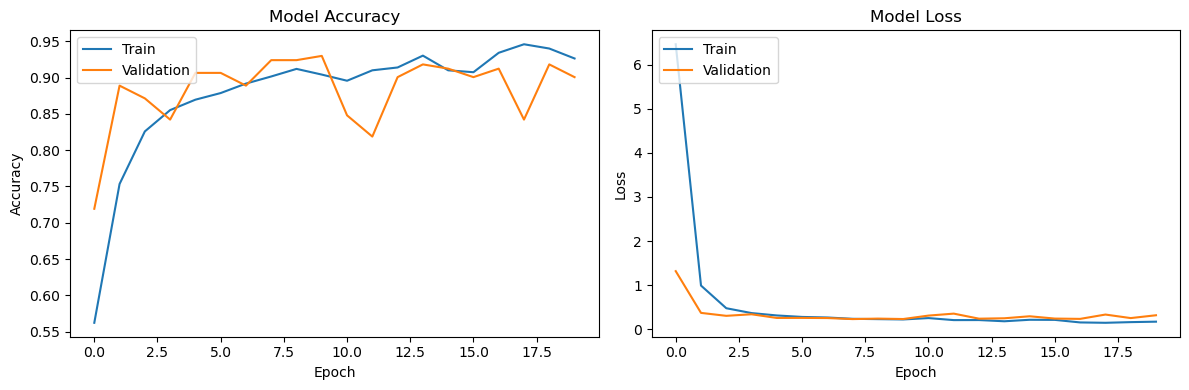

In [25]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyDenseNet169_8.history['accuracy'])
ax1.plot(historyDenseNet169_8.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyDenseNet169_8.history['loss'])
ax2.plot(historyDenseNet169_8.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_DenseNet169_8.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_DenseNet169_8.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_DenseNet169_8 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + DenseNet169 8:')
print(class_report_DenseNet169_8)

6/6 [==============================] - 6s 937ms/step - loss: 0.2334 - accuracy: 0.9298
validation accuracy: 92.982%
validation loss: 0.2334
6/6 [==============================] - 11s 1s/step
Classification Report Model CNN + DenseNet169 8:
              precision    recall  f1-score   support

      Opened       0.94      0.92      0.93        87
      Closed       0.92      0.94      0.93        84

    accuracy                           0.93       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171



Confusion Matrix:
[[80  7]
 [ 5 79]]


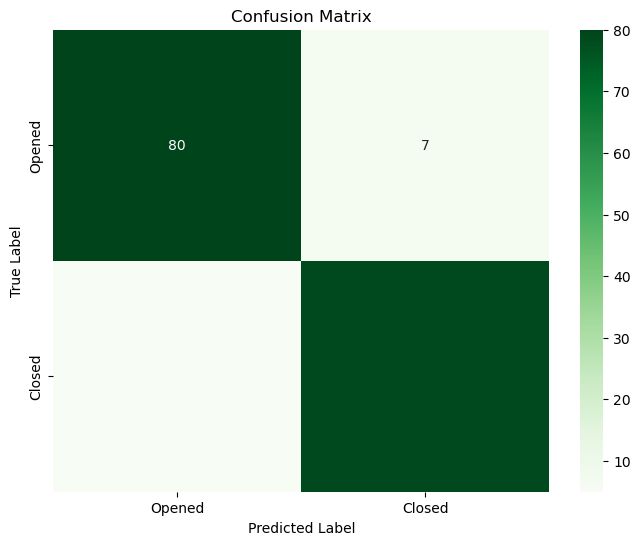

In [27]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model DenseNet169 8**

1/1 [==============================] - 0s 95ms/step


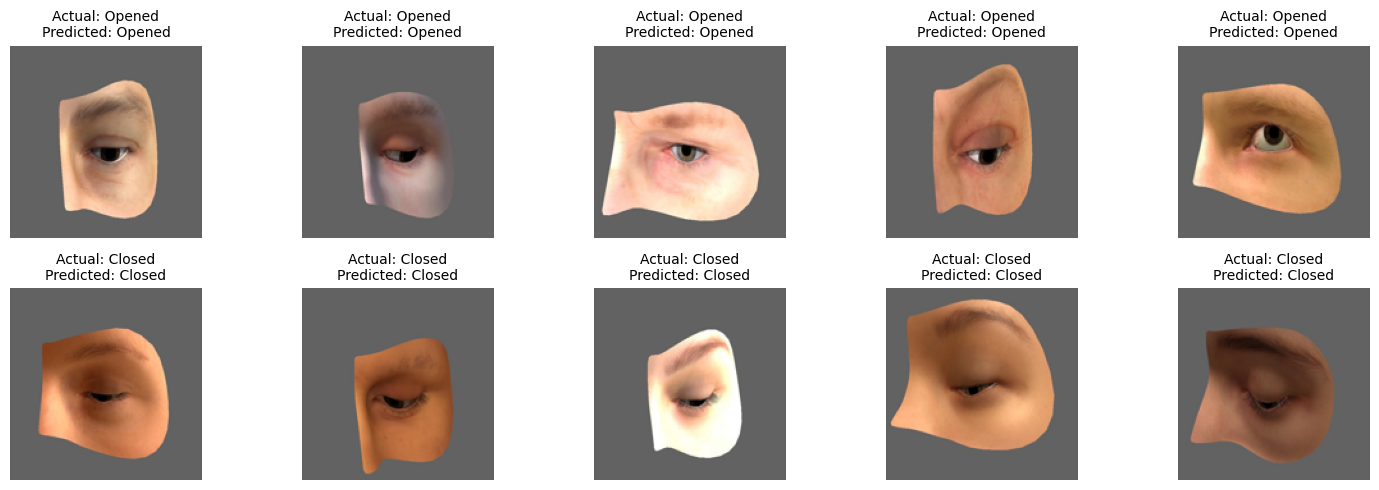

In [28]:
# Load model_predict_8 .h5
model_predict_8 = tf.keras.models.load_model('best_model_DenseNet169_8.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_8.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model Evaluation**

In [29]:
import time

# List model file paths
model_paths = [
    'best_model_DenseNet169_1.h5',
    'best_model_DenseNet169_2.h5',
    'best_model_DenseNet169_3.h5',
    'best_model_DenseNet169_4.h5',
    'best_model_DenseNet169_5.h5',
    'best_model_DenseNet169_6.h5',
    'best_model_DenseNet169_7.h5',
    'best_model_DenseNet169_8.h5'
]

# Placeholder untuk nama kategori
categories = ['Opened', 'Closed']  # Sesuaikan dengan kategori Anda

# Loop untuk mengevaluasi setiap model
for model_path in model_paths:
    print(f"\n# Evaluasi model: {model_path}")
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Start timer untuk runtime
    start_time = time.time()
    
    # Evaluasi model pada validation set
    validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation, verbose=1)
    
    # Prediksi untuk classification report
    y_pred = model.predict(x_validation, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_validation, axis=1)
    
    # Hitung runtime
    runtime = time.time() - start_time
    
    # Classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=categories)

    # confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Tampilkan hasil evaluasi
    print(f"\nRuntime: {runtime:.1f} s")
    print(f"Validation Accuracy: {validation_accuracy * 100:.3f}%")
    print(f"Validation Loss: {validation_loss:.4f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)



# Evaluasi model: best_model_DenseNet169_1.h5
6/6 [==============================] - 9s 1s/step

Runtime: 16.6 s
Validation Accuracy: 97.076%
Validation Loss: 0.2424
Classification Report:
              precision    recall  f1-score   support

      Opened       1.00      0.94      0.97        87
      Closed       0.94      1.00      0.97        84

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Confusion Matrix:
[[82  5]
 [ 0 84]]

# Evaluasi model: best_model_DenseNet169_2.h5
6/6 [==============================] - 9s 917ms/step

Runtime: 17.5 s
Validation Accuracy: 92.982%
Validation Loss: 1.1332
Classification Report:
              precision    recall  f1-score   support

      Opened       0.94      0.92      0.93        87
      Closed       0.92      0.94      0.93        84

    accuracy                           0.93       171
   macro avg       0.93      0.93  

## **Kesimpulan**

Pada project Computer Vision ini menggunakan algoritma Convolutional Neural Network yang disuntikan model transfer learning DenseNet169 dengan membandingkan jika sebuah Model CNN dilakukan trainable pada beberapa layer transfer learning, diberi atau tidak diberikan parameter regularizer dan perbedaan batch size. Kedelapan model CNN ini dapat dibandingkan untuk melihat model mana yang menghasilkan akurasi paling baik, runtime terendah, dan loss terendah. Berikut adalah hasil perbadingan akurasi dari keempat model:

1. Model CNN DenseNet169 1 dengan Trainable layer, dengan Regularizers, dan batch Size 32 ===> `Loss: 0.9851 ; Validation Acc: 97.6% ; F1-Score: 98% (21.6 s)`
2. Model CNN DenseNet169 2 tanpa Trainable layer, dengan Regularizers dan batch Size 32 =====> `Loss: 2.0065 ; Validation Acc: 95.9% ; F1-Score: 96% (19.4 s)`
3. Model CNN DenseNet169 3 dengan Trainable layer, tanpa Regularizers, dan batch Size 32 ====> `Loss: 0.1203 ; Validation Acc: 98.2% ; F1-Score: 98% (20.0 s`)
4. Model CNN DenseNet169 4 tanpa Trainable layer, tanpa Regularizers, dan batch Size 32 =====> `Loss: 0.2062 ; Validation Acc: 95.9% ; F1-Score: 96% (19.5 s)`
5. Model CNN DenseNet169 5 dengan Trainable layer, dengan Regularizers, dan batch Size 64 ===> `Loss: 3.1780 ; Validation Acc: 97.6% ; F1-Score: 98% (20.2 s)`
6. Model CNN DenseNet169 6 tanpa Trainable layer, dengan Regularizers, dan batch Size 64 ====> `Loss: 3.7391 ; Validation Acc: 95.9% ; F1-Score: 96% (19.3 s)`
7. **Model CNN DenseNet169 7 dengan Trainable layer, tanpa Regularizers, dan batch Size 64 ====> `Loss: 0.0937 ; Validation Acc: 98.2% ; F1-Score: 98% (20.5 s`)**
8. Model CNN DenseNet169 8 tanpa Trainable layer, tanpa Regularizers, dan batch Size 64 =====> `Loss: 0.1773 ; Validation Acc: 95.3% ; F1-Score: 95% (18.7 s)`

Seluruh model tidak memiliki overvitting maupun underfitting yang ditunjukan dari plot visualisasi loss dan akurasi data training dan validation. Oleh karena itu Model **CNN DenseNet169 7 dengan Trainable layer, tanpa Regularizers, dan batch Size 64** menjadi model paling baik untuk dataset model kantuk ini.

Untuk pemodelan lebih lanjut, data pada folder TrainingSet dapat ditambahkan data dari ImprovementSet untuk memperbanyak data dan bisa menambah akurasi yang dihasilkan nantinya.